# SD212: Graph mining

## Project

### Title: A graph analysis of crimes per department in France (2014)

### Students: Daniel Vahos, Paola Ortega

Note: The problems and solutions are in parts 2 and 3.

## 1. Introduction and Preprocessing

For the graph mining project we took data on the types of crimes and their respective amount per French department.
The aim was to find conclusions about the security situation in each region of France and to conclude if there is any relationship between the regions with respect to the crime rate of each  region.

### 1.1 Library Imports (code only)

In [1]:
from IPython.display import SVG

In [2]:
!pip install pandas

In [3]:
!pip install scikit-network

In [4]:
import numpy as np
import pandas as pd
from scipy import sparse

In [5]:
from sknetwork.data import load_netset, from_edge_list, linear_graph, miserables, from_adjacency_list, movie_actor
from sknetwork.linalg import normalize
from sknetwork.ranking import PageRank, top_k, Katz
from sknetwork.clustering import bimodularity
from sknetwork.visualization import svg_graph, svg_dendrogram, svg_bigraph
from sklearn import preprocessing

### 1.2 Pickle data

In [6]:
import pickle

# your names
name = 'ORTEGA_Paola__VAHOS_Daniel'
# url to your dataset, to be modified
url = 'https://nextcloud.r2.enst.fr/nextcloud/index.php/s/w7sBiFkk6Cx39eK'
# name of your notebook
name + '.ipynb'
# you need to download data first (see the above url)
with open(name, 'br') as f:
    dataset = pickle.load(f)

In [7]:
type(dataset)

sknetwork.utils.Bunch

In [8]:
dataset.biadjacency

<105x103 sparse matrix of type '<class 'numpy.float64'>'
	with 10815 stored elements in Compressed Sparse Row format>

The names are "name_crimes" and "name_dep"

In [9]:
dataset.name_crimes

array([['Règlements de compte entre malfaiteurs'],
       ["Homicides pour voler et à l'occasion de vols"],
       ["Homicides pour d'autres motifs"],
       ["Tentatives d'homicides pour voler et à l'occasion de vols"],
       ["Tentatives homicides pour d'autres motifs"],
       ['Coups et blessures volontaires suivis de mort'],
       ['Autres coups et blessures volontaires criminels ou correctionnels'],
       ["Prises d'otages à l'occasion de vols"],
       ["Prises d'otages dans un autre but"],
       ['Séquestrations'],
       ['Menaces ou chantages pour extorsion de fonds'],
       ['Menaces ou chantages dans un autre but'],
       ['Atteintes à la dignité et à la personnalité'],
       ['Violations de domicile'],
       ['Vols à main armée contre des établissements financiers'],
       ['Vols à main armée contre des établissements industriels ou commerciaux'],
       ['Vols à main armée contre des entreprises de transports de fonds'],
       ['Vols à main armée contre des part

In [10]:
dataset.name_dep

array([['Ain (01)'],
       ['Aisne (02)'],
       ['Allier (03)'],
       ['Alpes-de-Haute-Provence (04)'],
       ['Alpes-Maritimes (06)'],
       ['Ardèche (07)'],
       ['Ardennes (08)'],
       ['Ariège (09)'],
       ['Aube (10)'],
       ['Aude (11)'],
       ['Aveyron (12)'],
       ['Bas-Rhin (67)'],
       ['Bouches-du-Rhône (13)'],
       ['Calvados (14)'],
       ['Cantal (15)'],
       ['Charente (16)'],
       ['Charente-Maritime (17)'],
       ['Cher (18)'],
       ['Corrèze (19)'],
       ['Corse-du-Sud (2A)'],
       ["Côte-d'Or (21)"],
       ["Côtes-d'Armor (22)"],
       ['Creuse (23)'],
       ['Deux-Sèvres (79)'],
       ['Dordogne (24)'],
       ['Doubs (25)'],
       ['Drôme (26)'],
       ['Essonne (91)'],
       ['Eure (27)'],
       ['Eure-et-Loir (28)'],
       ['Finistère (29)'],
       ['Gard (30)'],
       ['Gers (32)'],
       ['Gironde (33)'],
       ['Guadeloupe (971)'],
       ['Guyane (973)'],
       ['Haute-Corse (2B)'],
       ['Haute-Garonne (31)

In [11]:
graph = dataset.biadjacency
name_crimes = dataset.name_crimes
name_dep =dataset.name_dep

### 1.3 Data Extraction

The following sources of data were used:
- Open Crime Data from the Police Nationale and Gendarmerie Nationale (https://crimes.politologue.com)
- INSEE’s population statistics (https://www.insee.fr/fr/statistiques/1893198)
- UNData’s population statistics for the departments that were not in INSEE’s study (French Polynesia, New Caledonia) (http://data.un.org/Default.aspx)

For the population statistics, it was as simple as downloading their CSV files and extracting the information for 2014. For the data related to crimes, there were not CSV files provided or an API, so we had to automate the navigation and the scraping of the data from the HTML pages (if interested, we can send you our script).


After wrangling with the data, these were the resulting main files used for the graph:
- crimes.csv: The name of every possible type of crime in the dataset.
- departments.csv: All the departments in France (both mainland and overseas)
- adjacency.csv: All the crime counts from every department. Each row represents a different department, and each column represents a different crime. The crimes and the departments are in the same order as the first 2 csv files described.
- standard-adjacency.csv: Each crime count is divided over the population of its respective department, and multiplied by 1000. This is to demonstrate the proportions of crimes relative to the amount of habitants, and provide a more fair distribution (because, of course, the more people live in a department, the more crimes that can be committed there).
- standard-edgelist.csv: An edgelist representation of the adjacency matrix. This is further explained in the next section.

### 1.3 Importing files


We’re working with a special case of undirected graphs with two disjoint sets of nodes for Crimes and Departments such that relationships only exist between these sets of nodes. On the other hand, two nodes of Departments cannot be connected nor can two nodes of Crimes. In our case, the two vector nodes for ‘types of crimes’ are the columns and ‘departments’ are the rows for the adjacency matrix. 

In [12]:
"""
crimes=pd.read_csv('crimes.csv', names=['Type of crime'])
crimes
"""

"\ncrimes=pd.read_csv('crimes.csv', names=['Type of crime'])\ncrimes\n"

In [13]:
#name_crimes=np.array(crimes)

In [14]:
"""
deps= pd.read_csv('departments.csv', names=['Department'])
deps
"""

"\ndeps= pd.read_csv('departments.csv', names=['Department'])\ndeps\n"

In [15]:
#name_dep= np.array(deps)

In [16]:
#df = pd.read_csv('standard-edgelist.csv', names=['department', 'crime', 'amount'])

In [17]:
#df

After the exhaustive extraction and organization of the data, in order to carry out the analysis, an import of the excel files is performed to form the matrices. 
Several forms of import were performed.

Our model would be a bipartite graph where the rows correspond to the departments and the columns correspond to the types of crimes, while the content within them is the quantity for each case. 

In [18]:
#edge_list = list(df.itertuples(index=False))

In [19]:
#graph = from_edge_list(edge_list, bipartite=True, weighted=True)

In the first instance an excel file was imported in edge_list mode, which consisted of 3 columns, which referred to the id of the department, the id of the crime and the number of crimes (or weight) of this respectively. 
Using the from_edge_list function we specified that it is a bipartite graph model with weight.
For the names of departments and crimes an import of other excel with each one of the names was made and thus the parameters name_crimes and name_dep were defined

In [20]:
#graph.shape

As can be seen, graph is a matrix containing 105 rows representing the 'departments' of France, and 103 columns representing the different types of 'crimes' considered for this analysis.

How it's a bipartite model. We denote the biadjacency matrix, possibly rectangular. The adjacency matrix of the graph seen as undirected is:

The adjacency matrix given is as follows
$A = \begin{pmatrix}
        0 & B\\
        B^{T} & 0 \\
\end{pmatrix} $

In [21]:
image = svg_bigraph(graph,name_dep,name_crimes, edge_width=50,edge_color= 'blue', scale= 4, color_row= 'red', color_col= 'green')
image[1:4]

'svg'

To visualize, we mainly use the function svg_bigraph, this function allows us to indicate the matrix, along with the names and characteristics of the bipartite graph that we want. 
Specifically for our case, as it is a bipartite graph that contains many connections and a great amount of parameters, to be able to be visualized it is necessary to have in the parameters a large scale. \
\
Having the image defined to visualize it, a Public API for display tools in IPython is used, importing SVG (for vector drawings).

In [22]:
graph

<105x103 sparse matrix of type '<class 'numpy.float64'>'
	with 10815 stored elements in Compressed Sparse Row format>

The bipartite graph of our analysis is shown below: 

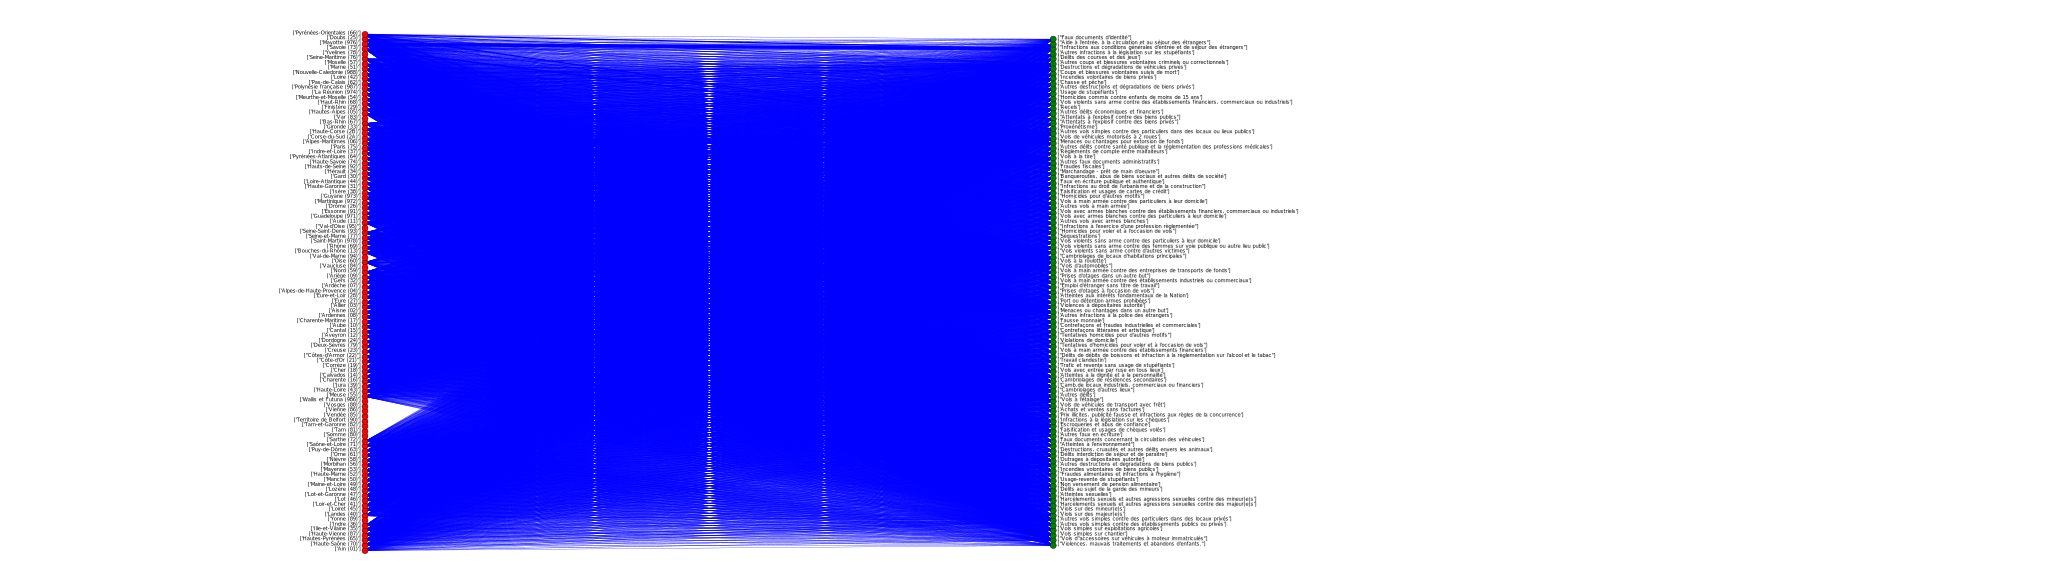

In [23]:
SVG(image)

## 2. Ranking Algorithms

We used 2 different ranking algorithms for our graph: PageRank and Katz Centrality. We also proposed 3 ranking-related questions:
- Q2.1. Which are the most affected areas for crimes related to child rape?
- Q2.2. Which are the most affected areas for crimes related to fiscal fraud?
- Q2.3. How different are the ranking results of PageRank and Katz?

In [24]:
from sknetwork.clustering import Louvain, modularity, bimodularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

### 2.4 PageRank

In order to make a conclusive analysis, the ranking method can be used, which is in charge of making a classification by giving priority to the nodes that have more connections or have greater weight. Different restrictions can also be added to perform the ranking according to a parameter or one of the nodes. 
This type of algorithm is very applicable for real life recommendation systems, in which by means of a parameter of some user, different things are recommended that are as related as possible to this topic. 

In [25]:
pagerank= PageRank()

For our specific analysis of the types of crimes with the departments, we use it in order to identify the ranking of departments that commit crimes in France

In [26]:
scores = pagerank.fit_transform(graph)


In [27]:
top_dep=name_dep[top_k(scores, 5)]
top_dep

array([['Paris (75)'],
       ['Saint-Martin (978)'],
       ['Seine-Saint-Denis (93)'],
       ['Bouches-du-Rhône (13)'],
       ['Guyane (973)']], dtype=object)

And we can see the case for the places with more crimes in France. In this case as we can see, “Saint Martin”, “Martinique”, “Guyane”, and “Guadeloupe” are regions in the Caribbean Sea area, which show high proportions of insecurity. This makes sense when recognizing that usually the Latin American region tends to have higher levels of insecurity than the European region. Paris is also one of the first regions in crime in France, this is something completely reasonable because Paris is one of the most populated cities, with more commercial, social and economic movement. \
\
It is worth remembering that this ranking does not necessarily indicate the places with the most crime, but with the highest crime rates according to their population. 

We took the trouble to investigate in the media, and found that the Saint Martin department is indeed considered the most dangerous in France.

#### 2.4.1 What about specific crimes?

### Question 2.3: Which are the most affected areas for crimes related to child rape?

In order to go deeper, and to solve one of our questions that concerned us from the beginning of this project. To find conclusions about one of the most delicate crimes in our opinion, which is the rape of minors. 
\
\
We seek to find the possible regions most affected by this issue. 

In [28]:
scores = pagerank.fit_transform(graph, seeds_col=name_crimes.ravel()=='Viols sur des mineur(e)s')

In [29]:
# The top departments for child rape
top_dep=name_dep[top_k(scores, 5)]
top_dep

array([['Guyane (973)'],
       ['Paris (75)'],
       ['Saint-Martin (978)'],
       ['Polynésie française (987)'],
       ['Guadeloupe (971)']], dtype=object)

### Top departments for child rape
##### Guyane
##### Paris
##### Saint-Martin
##### Polynésie française
##### Guadeloupe

It is understood that after Guyane, the place with the highest number of child rape is Paris. And it’s also interesting to know that  “Polynésie française” which wasn’t in the top departments of crimes is actually in the top for child rapes. 

In [30]:
# The top crimes in the selected departments (top5 dep for child rape)
top_crimes_viol=name_crimes[top_k(scores, 5)]
top_crimes_viol

array([['Vols de véhicules motorisés à 2 roues'],
       ['Destructions, cruautés et autres délits envers les animaux'],
       ['Autres faux en écriture'],
       ['Chasse et pêche'],
       ["Vols d'automobiles"]], dtype=object)

So by emphasizing on these regions, we are interested in knowing what are the most common crimes in this place. 

As we can see, the most common crime for Guyane is 'Vols de véhicules motorisés à 2 roues'.
Although the rape of minors is common in this region, this crime is not the most common crime of the place, as it can be seen it is not part of the top crimes of the department, on the contrary. It's also interesting to see how "chasse et peche" it's the most commited crime in Polynesie française which has some sense because it's an island. 

In [31]:
# scores for columns
scores_ = pagerank.scores_col_

In [32]:
#sum of scores for crimes
np.sum(pagerank.scores_row_)

0.369003652059668

In [33]:
#sum of scores for departments
np.sum(pagerank.scores_col_)

0.6309963479403321

In [34]:
all(pagerank.scores_==pagerank.scores_row_)

True

In [35]:
# Top related crimes for child rape 
name_crimes[top_k(scores_, 5)]

array([['Viols sur des mineur(e)s'],
       ['Autres vols simples contre des particuliers dans des locaux ou lieux publics'],
       ['Vols à la roulotte'],
       ['Autres coups et blessures volontaires criminels ou correctionnels'],
       ['Autres vols simples contre des particuliers dans des locaux privés']],
      dtype=object)

As can be seen, with these previous results, our conclusion is that it’s very difficult to find a relationship between the rape crime cases to the other crimes, because there is not much of a clear relationship between these other ones. 

####  2.4.2 What about judicial crimes?

### Question 2.4: Which are the most affected areas for crimes related to fiscal fraud?

In order to look at the statistics of crimes other than rape, we searched for a judicial crime such as Tax Fraud and analyzed the result. 

In [36]:
scores4 = pagerank.fit_transform(graph, seeds_col=name_crimes.ravel()=='Fraudes fiscales')

As we can see here, there's no much relation with child rape with other crimes, here there are some other cases of thefts.

In [37]:
top_crimes4=name_dep[top_k(scores4, 5)]
top_crimes4

array([['Paris (75)'],
       ['Corse-du-Sud (2A)'],
       ['Alpes-Maritimes (06)'],
       ['Haute-Garonne (31)'],
       ['Aude (11)']], dtype=object)

As it can be seen, 
##### Paris, 
##### Corse du Sud and 
##### Alpes Maritimes, 
are the regions with most tax fraud

### 2.5 Katz Centrality

Although not mentioned in the lectures, we decided to opt for a second clustering algorithm to compare and contrast it with the PageRank results. Katz’s centrality algorithm uses the measure of centrality in a network in order to rank its nodes based on their relative degree of influence to other nodes in the network.

This algorithm has a similar algorithmic approach than PageRank, the difference being that PageRank is newer and solves the problem of Katz’s high centrality ambiguity (https://www.sci.unich.it/~francesc/teaching/network/pagerank): in Katz, a node with high centrality might mean that the nodes it links with will also have high centrality, which is not necessarily true.


In [38]:
katz = Katz()

In [39]:
scores = katz.fit_transform(graph)

There is another big difference between Katz and PageRank: PageRank allows to do personalized ranking as well as general ranking. Katz, on the other hand, can only perform the latter. Therefore, it is not possible to answer questions 2.1 and 2.2 using this algorithm. Instead, we can look at the ranking of both crimes in terms of their level of centrality.

In [40]:
scores_row = katz.scores_row_
scores_col = katz.scores_col_
names_row = name_dep
names_col = name_crimes

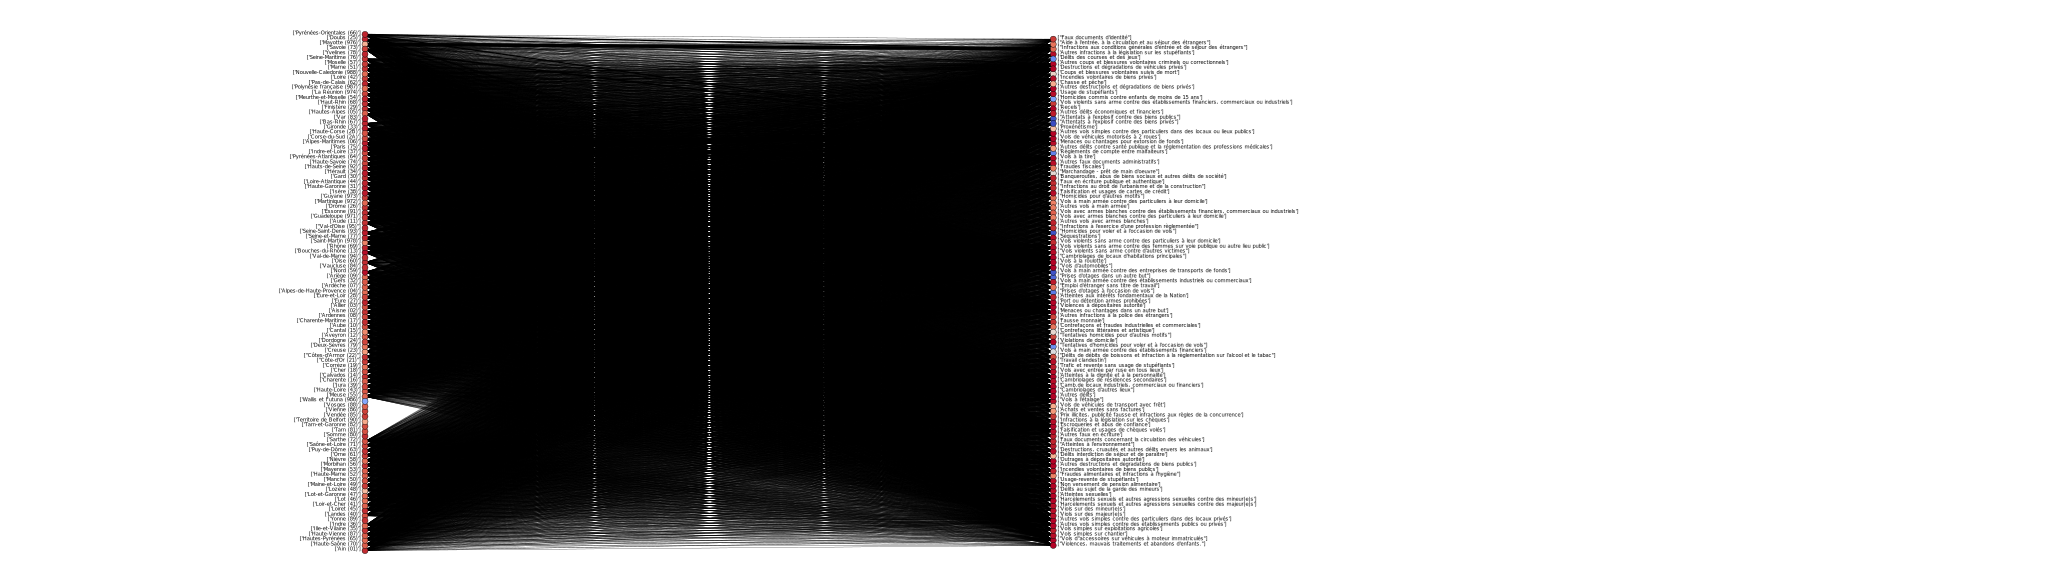

In [41]:
image = svg_bigraph(graph, names_row, names_col, scores_row=scores_row, scores_col=scores_col, scale=4)
SVG(image)

In [42]:
import operator
pos_scores = {k: v for k, v in enumerate(scores_row)}
ranking_region = sorted(pos_scores.items(), key=operator.itemgetter(1), reverse=True)
pos_scores = {k: v for k, v in enumerate(scores_col)}
ranking_crime = sorted(pos_scores.items(), key=operator.itemgetter(1), reverse=False)

In [43]:
mineurs = [idx+1 for idx, item in enumerate(ranking_crime) if item[0] == 46]
print(f"Answer for Q2.1 (modified): the centrality ranking of crime 'Viols sur des mineur(e)s' is {mineurs[0]} out of 103")

Answer for Q2.1 (modified): the centrality ranking of crime 'Viols sur des mineur(e)s' is 56 out of 103


In [44]:
fiscales = [idx+1 for idx, item in enumerate(ranking_crime) if item[0] == 100]
print(f"Answer for Q2.2 (modified): the centrality ranking of crime 'Fraudes fiscales' is {fiscales[0]} out of 103")

Answer for Q2.2 (modified): the centrality ranking of crime 'Fraudes fiscales' is 24 out of 103


To answer question 2.3, we obtained the ranking of the top 5 departments with strongest centrality scores using Katz:

In [45]:
print("Top 5 departments with strongest crime variety and intensity")
for i in range(0,5):
  name = names_row[ranking_region[i][0]][0]
  score = ranking_region[i][1]
  print(f"Position #{i+1}: {name} with a score of {score}")

Top 5 departments with strongest crime variety and intensity
Position #1: Bouches-du-Rhône (13) with a score of 5237874.125
Position #2: Nord (59) with a score of 5225737.9375
Position #3: Gironde (33) with a score of 5191968.5625
Position #4: Haute-Garonne (31) with a score of 5188605.6875
Position #5: Seine-Saint-Denis (93) with a score of 5188565.8125


As we can see, the results are quite different than the ones using PageRank. For starters, Saint-Martin is not there, and neither is Paris (but it is in the top 10). We can see though that Bouches-du-Rhone shares a top 3 in both algorithms. We believe the big differences in ranking is due to Katz's high centrality ambiguity that we explained later.

## 3. Clustering Algorithms

We used 2 different clustering techniques for our graph: Louvain and Paris Dendrogram. We proposed 2 ranking-related problems:
- 3.1 Which are the crimes that show a bigger differential factor that separates them from the rest?
- 3.2 Do the departments in the clusters seem to be geographically close?

### 3.3 Louvain Algorithm

In this case, we seek to find a clustering in the different nodes, to identify which ones are more related than others. With Louvain's algorithm, communities can be formed based on the node's edge density. Communities would form where the connectivity of the edges is very dense. 

On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. If no positive gain is achieved the node remains in its original community.

$$max  Q_{(C)}$$

Initially we use a resolution of 1

In [46]:
louvain = Louvain()
louvain.fit(graph)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

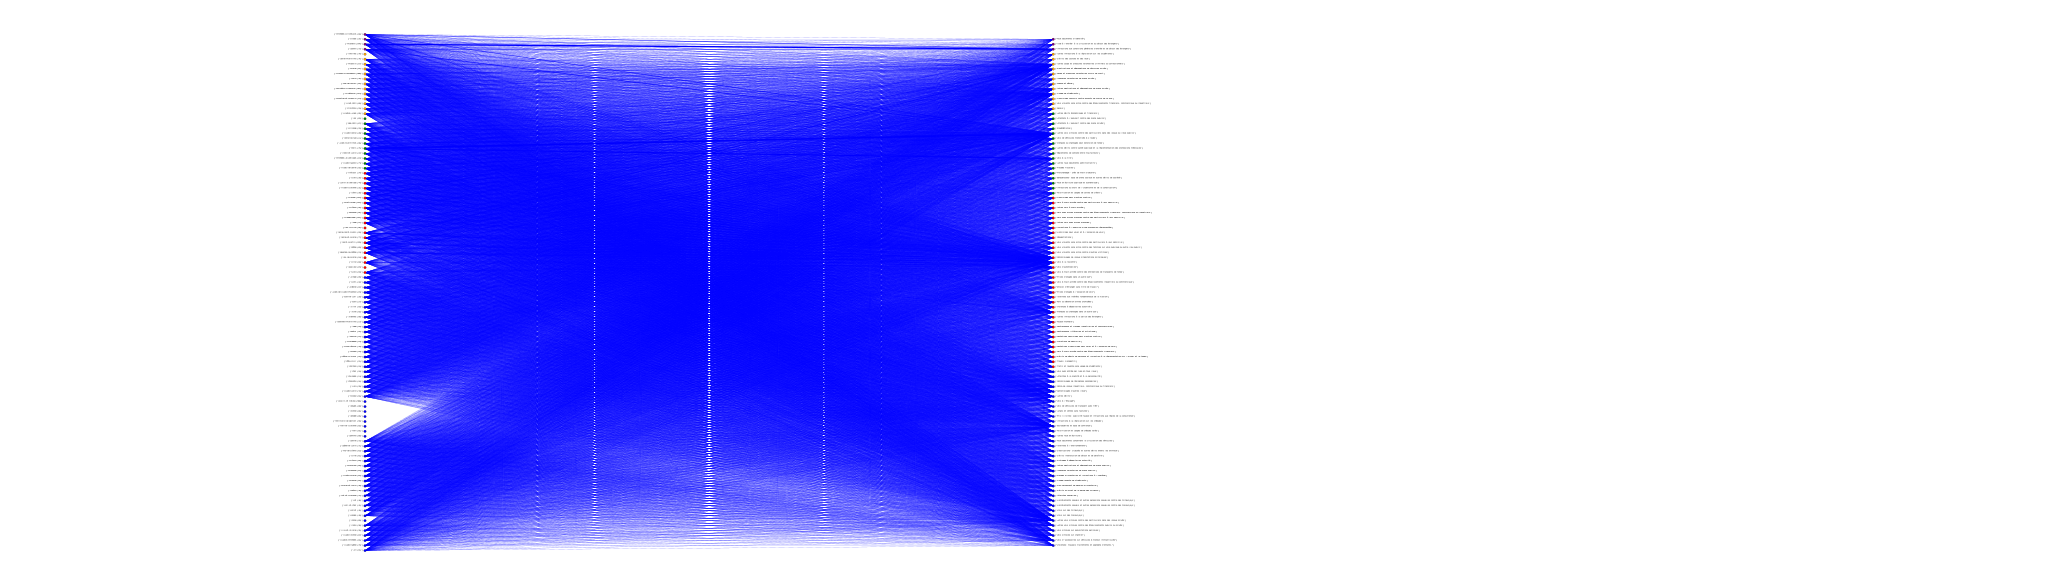

In [47]:
image_louvain = svg_bigraph(graph,name_dep,name_crimes, labels_row, labels_col, edge_width=50,edge_color= 'blue', scale= 10, color_row= 'red', color_col= 'green')

SVG(image_louvain)

### Question 4: Which are the crimes that show a bigger differential factor that separates them from the rest?

In this case, after having performed the grouping by means of Louvain, a small grouping-community containing specifically 3 crimes can be found. So our answer to this question posed at the beginning is that the crimes that show a bigger differential factor from the rest are : 
\
##### "Faux documents d'identité", 

##### "Aide à l'entrée, à la circulation et au séjour des étrangers",

##### "Infractions aux conditions générales d'entrée et de séjour des étrangers".

Interestingly, the crimes for this response focus specifically on immigration-related crimes. These crimes, although they may be a large number, are distinct from the others.

The following is the formula of bimodularity which is goint to be applied by the algorith shown  below:

### Bi-modularity

Bi-modularity:
$$ Q = \sum_{i} \sum_{j} (\frac {B_{ij}}{w} -\alpha \frac {d_{1,i}d_{2,j}}{w^{2}}) \delta_{c_{1,i},c_{2,j}} $$


Where: 
\
$c_{1,i},c_{2,j}$ are the clusters of i(departments) and j(crimes) \
$d_{1,i}d_{2,j}$ are the weights (quantities in our case) of the nodes for the connection of i (departments) and j(crimes) \
$w$ is the total weight of our graph \
$\alpha$ would be the resolution parameter

Modularity is a score between -0.5 and 1 which indicates the density of edges within communities with respect to edges outside communities. Using the louvain's algorithm we're optimizing the modularity to find the best group of communities in crimes and departments. 
It can also be seen as the difference between the probability between the probability that a random walk stays is the same cluster after a move and the probability that two independent random walks are in the same cluster.

In [48]:
bimodularity(graph, labels_row, labels_col)

0.08107867542304759

In our case, as the bimodularity gave us very close to 0, we conclude that there is very low density in the connections inside the communities, with respect to the connections outside the communities. 

Analyzing our situation in the graph with the clusters by means of Louvain, we could see with respect to the bimodularity that the resolution parameter tends to be low because the fit term dominates, as we can see that there is a very large clustering of a large number of the departments and crimes in a single community, which is the blue one. 

#### 3.3.1 Aggregate graph

Also, part of the analysis is to be able to visualize such clusterings together in a single node, which can be achieved by means of the Aggregate graph. The number of nodes in this graph would be the number of clusters you made for the departments and crimes divided into communities. 

The formula to get this graph is obtained through the Membership Matrix, which ends up being a binary matrix. 
To do this we just sum all the edge weights between nodes of the corresponding communities to get a single weighted edge between them, and collapse each community down to a single new node. 

In [49]:
# aggregate graph
biadjacency_aggregate = louvain.aggregate_

In [50]:
labels_unique_row, counts_row = np.unique(labels_row, return_counts=True)
labels_unique_col, counts_col = np.unique(labels_col, return_counts=True)

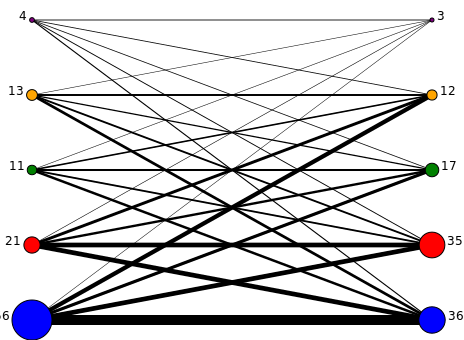

In [51]:
image_louv2 = svg_bigraph(biadjacency_aggregate, counts_row, counts_col, labels_unique_row, labels_unique_col,
                    display_node_weight=True, node_weights_row=counts_row, node_weights_col=counts_col)
SVG(image_louv2)

In [52]:
# soft clustering
scores_row = louvain.membership_row_[:,1].toarray().ravel()
scores_col = louvain.membership_col_[:,1].toarray().ravel()

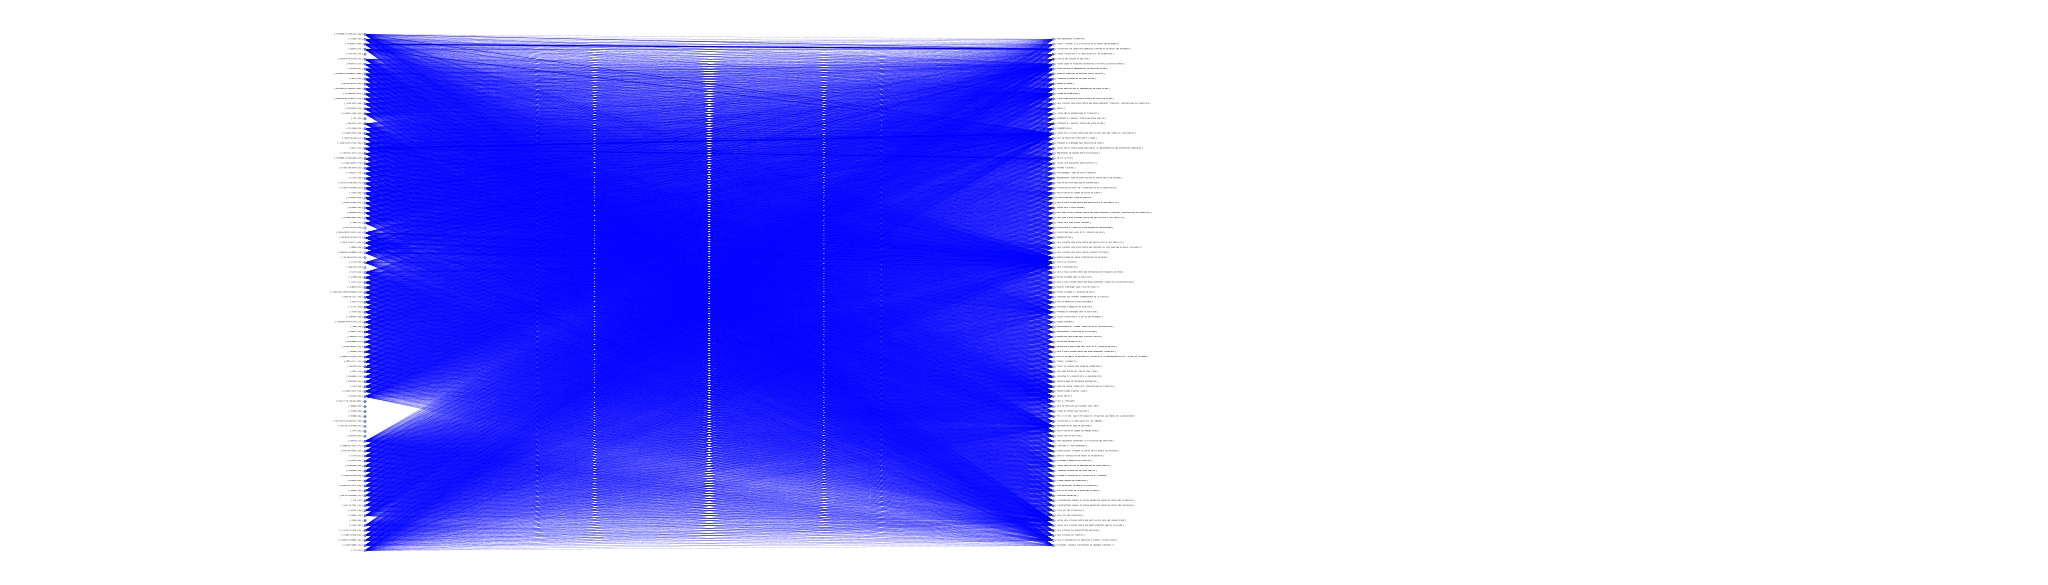

In [53]:
image_louv3 = svg_bigraph(graph,name_dep,name_crimes,scale= 10, scores_row=scores_row, scores_col=scores_col,display_edge_weight= True, edge_width=0.5,edge_color= 'blue')
SVG(image_louv3)

In this case, it is less easy to identify the differences between the crimes. However, there are some that stand out as "Autres vols à main armée". Tentatives d'homicides pour voler et à l'occasion de vols" which appear to be strongly differentiated and have a very low probability or no relationship with the main clustering in which most of the crimes are found. 

### Louvan with more resolution

Louvain's algorithm allows us to adjust the resolution. However, as the article
"Hierarchical Graph Clustering using Node Pair Sampling" says, it's explained that the resolution parameter available in the current version of the algorithm is not directly related to the number of clusters or the cluster sizes and thus is hard to adjust in practice.

That's why we use just a resolution of our preference. 

In [54]:
louvain = Louvain(resolution=10)
louvain.fit(graph)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_

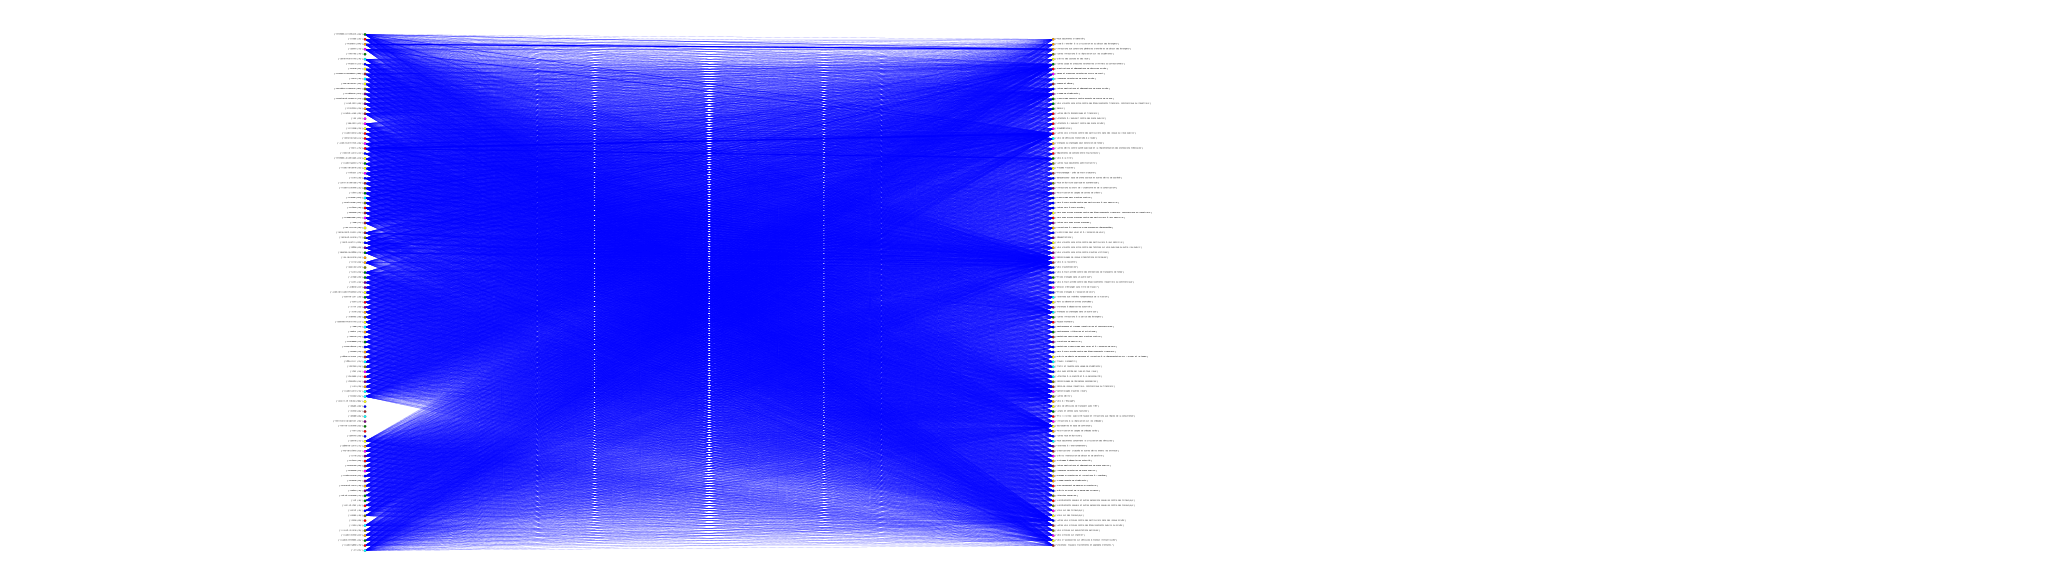

In [55]:
image_louvain = svg_bigraph(graph,name_dep,name_crimes, labels_row, labels_col, edge_width=50,edge_color= 'blue', scale= 10, color_row= 'red', color_col= 'green')

SVG(image_louvain)

In [56]:
bimodularity(graph, labels_row, labels_col)

0.007166719741748802

In [57]:
biadjacency_aggregate = louvain.aggregate_

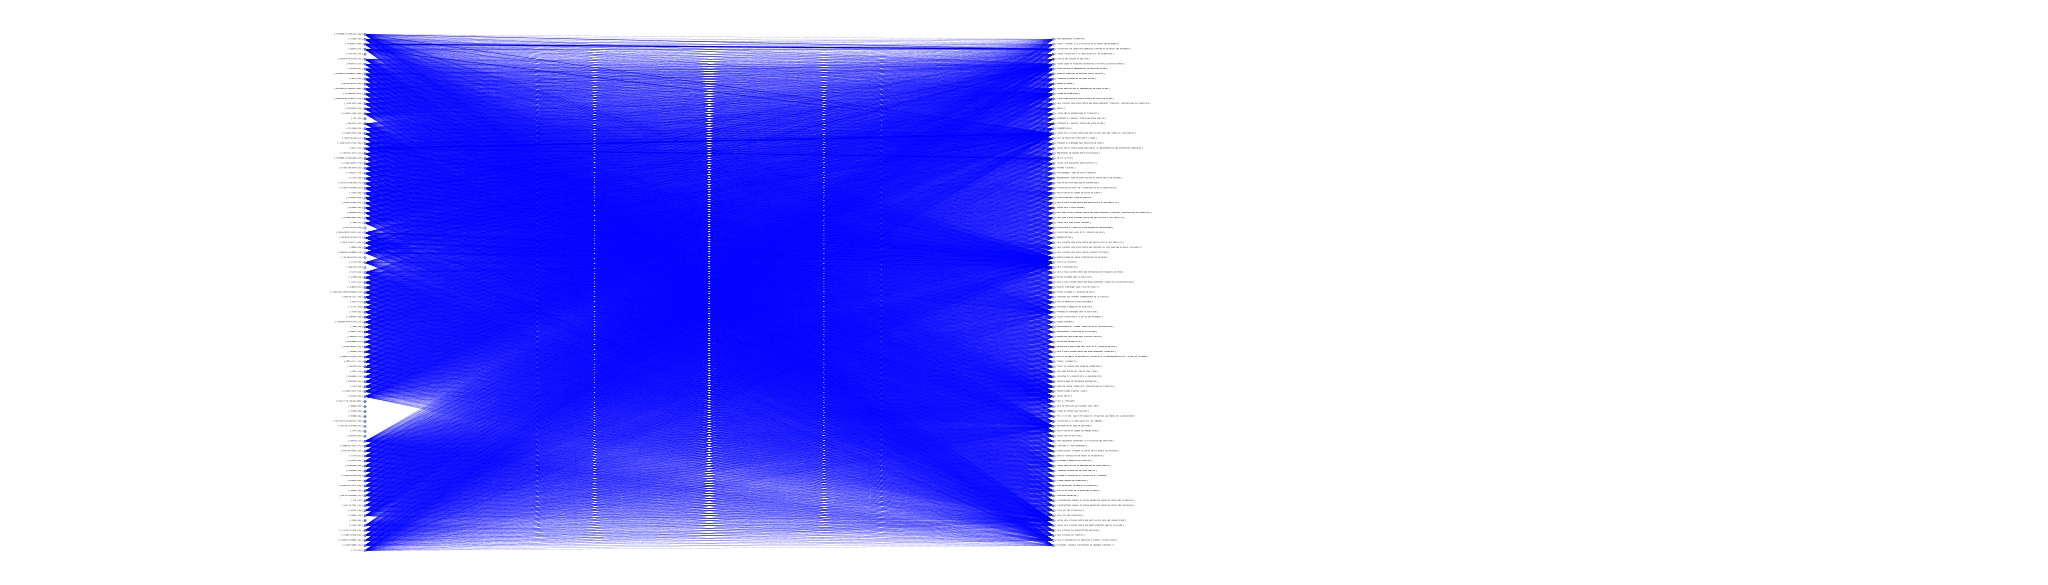

In [58]:
image_louv3 = svg_bigraph(graph,name_dep,name_crimes,scale= 10, scores_row=scores_row, scores_col=scores_col,display_edge_weight= True, edge_width=0.5,edge_color= 'blue')
SVG(image_louv3)

### 3.4 Dendrogram (using Paris algorithm)

We decided to opt for a hierarchical clustering algorithm in order to visualize how the algorithm allocates the crimes/departments to clusters. In the end, we went for the Paris algorithm since we had already used it in the lab, and merges nodes based on similarity, which gives a good point of comparison with Louvain.

In [59]:
from sknetwork.hierarchy import Paris

In [60]:
names_row = name_dep
names_col = name_crimes

In [61]:
paris = Paris()
paris.fit(graph)
dendrogram = paris.dendrogram_

In [62]:
dendrogram_row = paris.dendrogram_row_
dendrogram_col = paris.dendrogram_col_
dendrogram_full = paris.dendrogram_full_

Since Louvain does a 5-fold partition, we decided to instantiate to the Dendrogram algorithm to build 5 clusters as well (n_clusters). 

To answer question 3.1, we need to clarify that the crimes with the biggest differencial factor are the ones that have the longest distance from the rest of the clusters, which is the yellow cluster. We can observe that most of the crimes also match with the ones observed using Louvain. 

We believe this is because we went with the default parameters of Louvain, including the resolution parameter being 1. Therefore, Louvain gets run the same amount of times than Paris. Since they are both greedy algorithms with similar characteristics, it is not surprising that we get such similar results.

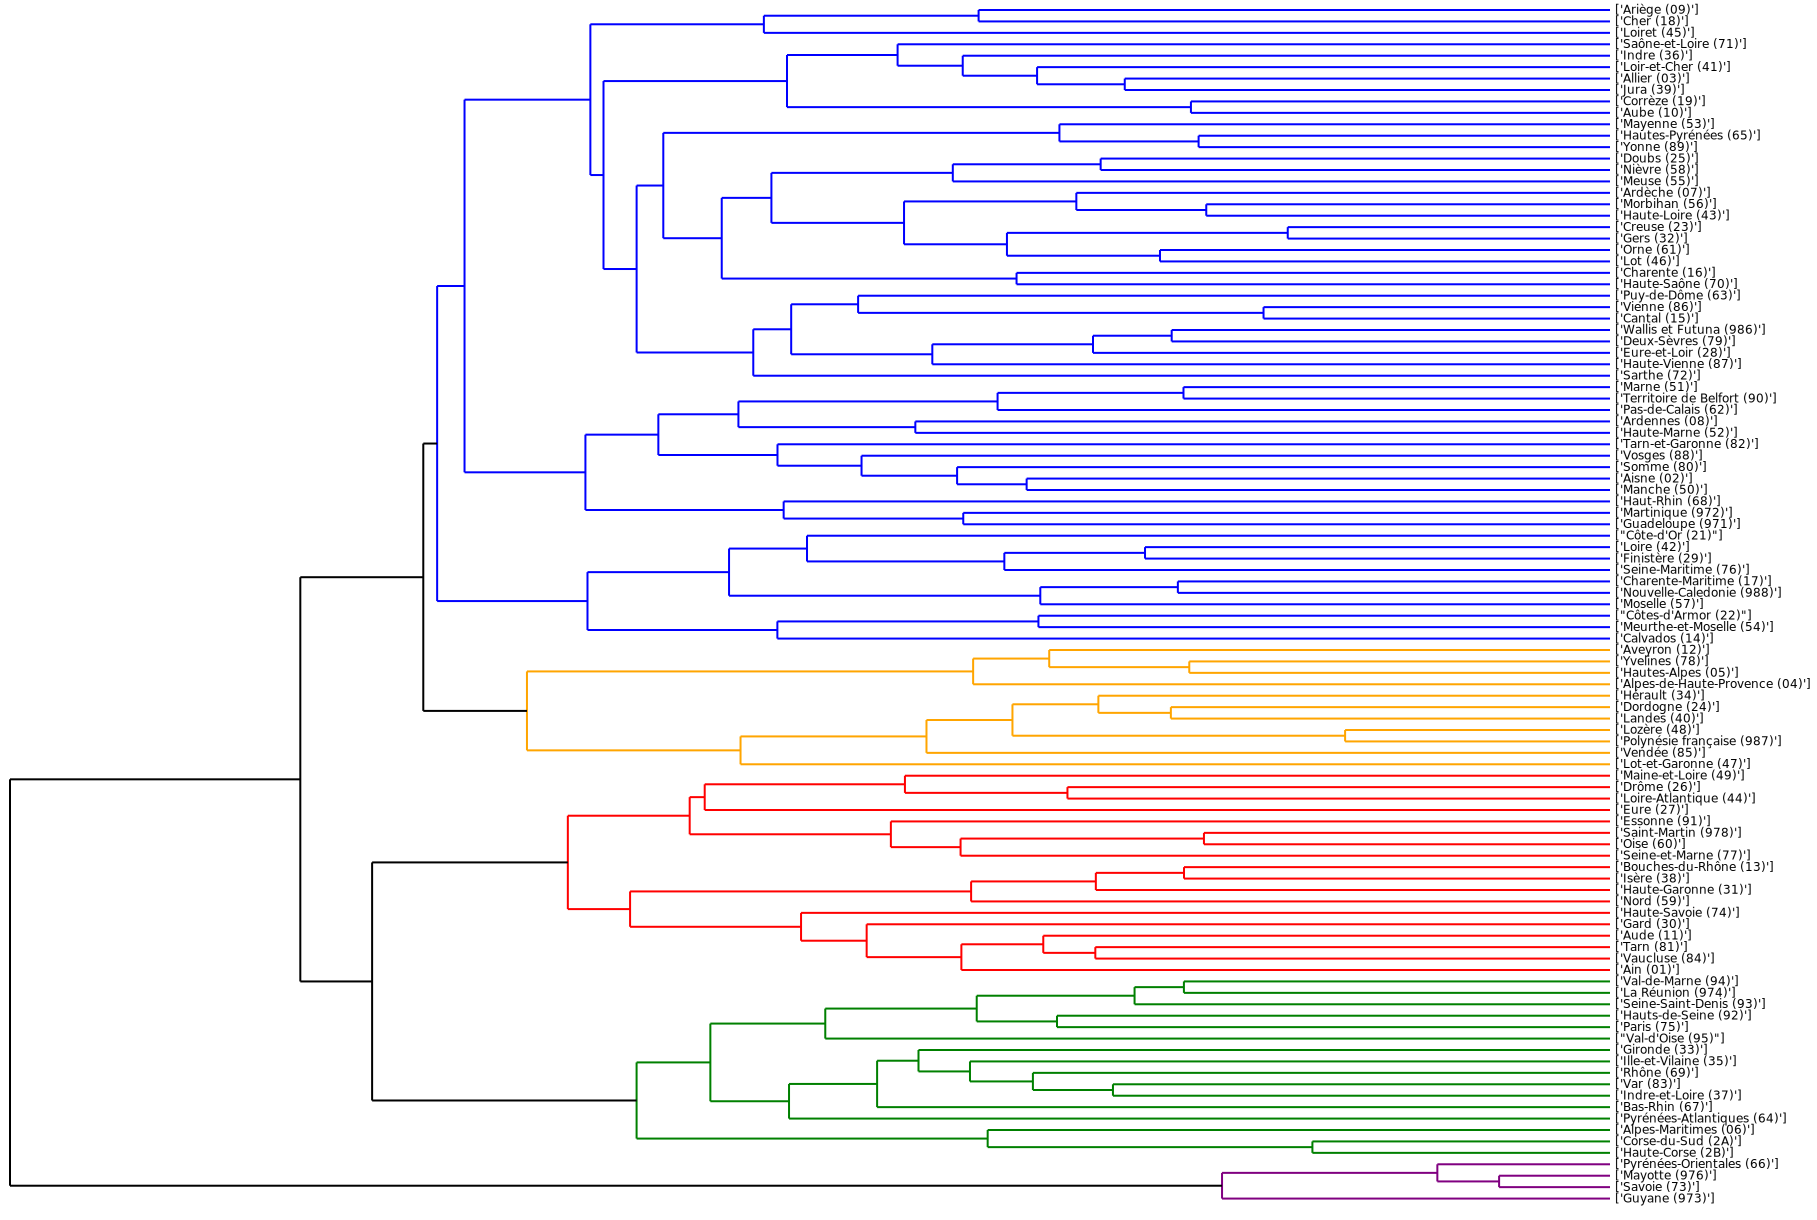

In [63]:
image = svg_dendrogram(dendrogram_row, names_row, n_clusters=5, rotate=True, scale=4)
SVG(image)

To answer quetion 3.2, we need to look at each cluster obtained from the department dendrogram. It was noticeable that the biggest cluster, the blue one, got together many departments that did not have much to do with each other except the fact that they probably did not provide as much crime information as other departments. The departments located around the Alps seem to be mostly concentrated in the yellow, with some of them in the green cluster too. In conclusion, there does not seem to be a particular relation between the crimes and the location, but probably some of the neighboring departments have similar population sizes and characteristics, which affects their similarity scores and in turn end up in the same cluster.

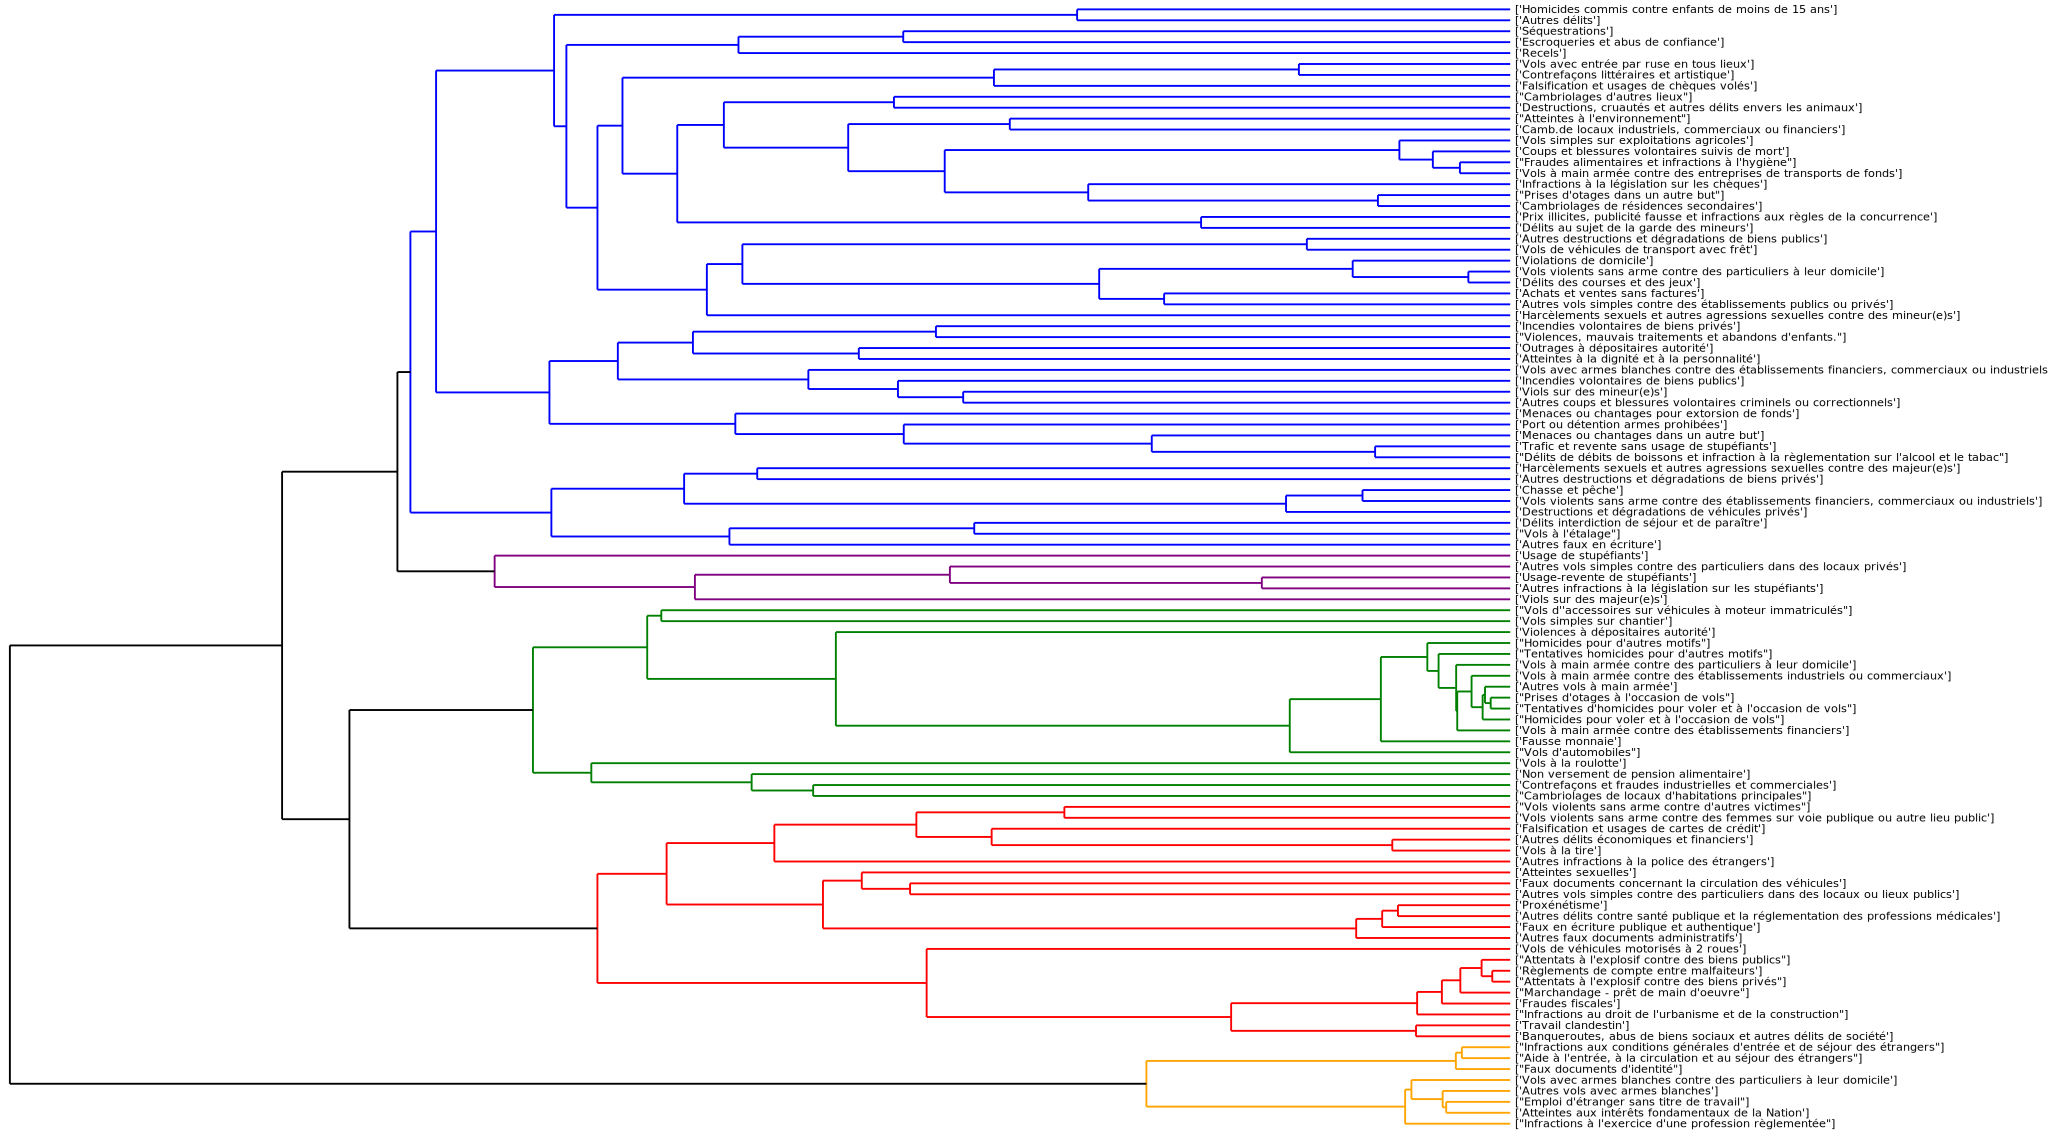

In [64]:
image = svg_dendrogram(dendrogram_col, names_col, n_clusters=5, rotate=True, scale=4)
SVG(image)

## 4. Conclusion

In this project it could be proven that a graph analysis depends on the algorithm that is being used. We arrived to same conclusions with kind of different results. 
We would have liked to apply the fine tunning algorithms in order to make the most accurate analysis possible.
Different more specific and technical conclusions were made during the explanations of every algorithm we developped on this project. 